In [1]:
#IMPORTS

#your standard python data manipulation mirepoix
import pandas as pd
import numpy as np
# plotting libraries
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
#A library that reads .bam files an important NGS datafile
import pysam
#Scaling, normalizing, filtering
from sklearn.preprocessing import scale, normalize
from scipy.ndimage.filters import gaussian_filter as GF
#multiprocess
from multiprocessing import Pool
#pickle
import pickle

## Some helper functions

In [2]:
def worker(nsample):
    """This is executed by each multiprocess worker, it opens a bam file
    extracts reads in a specific way and outputs a numpy matrix of counts"""
    
    #fax fragment size to take into account
    #also the number of rows in the output matrix
    maxTLEN = 500
    #offset some fragment lengths, the lengths from 0-40 have no reads
    tlenoffset = 40
    
    nt,sample = nsample
    g_stage,g_iT = nt
    
    bam = pysam.AlignmentFile(bfD[sample.iloc[0]['stage']])
    wl = sample.iloc[0]['end'] - sample.iloc[0]['start']
    wc = np.zeros((maxTLEN,wl), dtype=np.int32)
    wt = np.zeros((maxTLEN,wl), dtype=np.int32)
    

    for i, row in sample.iterrows():
            chrom, start, end,_,_,iT,strand,sset = row.tolist()
            for read in bam.fetch(chrom, start, end, multiple_iterators=True):    
                if read.is_proper_pair:
                    tlen = abs(read.template_length)
                    tlenp = tlen - tlenoffset
                    if 0 <= tlenp <maxTLEN:

                        if read.is_reverse:
                            dpos = read.reference_end
                            if strand == '-':
                                cis = True
                                dpos = wl -1 -dpos
                            else:
                                cis = False
                        else:
                            dpos = read.reference_start
                            if strand == '+':
                                cis = True
                            else:
                                cis = False
                                dpos = wl -1 -dpos

                        dpos = dpos-start

                        if 0 <= dpos < wl:
                            if cis:
                                wc[tlenp][dpos] += 1
                            else:
                                wt[tlenp][dpos] += 1
    return g_stage, g_iT, wc,wt


def extend(m, E):
    """Takes a 2D matrix and extends the signal by E positions to the right"""
    C = E+1
    pm = np.pad(m, ((0,0),(C,C)), mode='constant')

    M = np.zeros(m.shape)
    for i in range(1,C):
        M += np.roll(pm,i)[:,C:-C]
    return M

In [9]:
# A dictionary holding the bam file filepaths.
bfD = {
"forebrain_0": "/home/ska/OtherLabsRAW/ATACseq/Mouse/forebrain/mm10_br_forebrain_0dpf_comb.bam",
"lung_0": "/home/ska/OtherLabsRAW/ATACseq/Mouse/lung/mm10_br_lung_0dpf_comb.bam",
"liver_0": "/home/ska/OtherLabsRAW/ATACseq/Mouse/liver/mm10_br_liver_14d_comb.bam",
"hindbrain_0": "/home/ska/OtherLabsRAW/ATACseq/Mouse/hindbrain/mm10_br_hindbrain_0dpf_comb.bam",
"lung_14": "/home/ska/OtherLabsRAW/ATACseq/Mouse/lung/mm10_br_lung14.comb.bam",
"stomach_0": "/home/ska/OtherLabsRAW/ATACseq/Mouse/stomach/mm10_br_stomach_0dpf_comb.bam",
"heart_0": "/home/ska/OtherLabsRAW/ATACseq/Mouse/heart/mm10_br_heart_0d_comb.bam",
"liver_14": "/home/ska/OtherLabsRAW/ATACseq/Mouse/liver/mm10_br_liver_14d_comb.bam",
"intestine_0": "/home/ska/OtherLabsRAW/ATACseq/Mouse/intestine/mm10_br_intestine_0dpf_comb.bam",
"midbrain_0": "/home/ska/OtherLabsRAW/ATACseq/Mouse/midbrain/mm10_br_midbrain_0d_comb.bam",
"kidney_0": "/home/ska/OtherLabsRAW/ATACseq/Mouse/kidney/mm10_br_kidney_0d_comb.bam"
}

In [10]:
# This dataframe contains a set of PWM potential hits
#each line references a postition on the genome (chromosome, start, end), the stage in which 
#this target is relevant, a score (not used here), iT: a  mark of whether the site is true or not,
#and a final field called set which is also not relevant here
df = pd.read_csv("/home/ska/panos/PubNimrod/datasets/dataset_mm_M6125.tsv",index_col=0,
           sep='\t')
# we extend each position by 500 bases upstread and downstream since we want to collect data from
#a wider site
df['start'] = df['start'] - 500
df['end'] = df['end'] + 500
df = df[df.start>0]

In [11]:
df.head()

chrom    start      end        stage     score  iT strand         set
0  chr1  3113213  3114228  forebrain_0  9.290323   0      +       train
1  chr1  3670910  3671925  forebrain_0  8.516129   0      -       train
2  chr1  3671049  3672064  forebrain_0  8.538460   0      -       train
3  chr1  3671170  3672185  forebrain_0  8.684865   0      +  validation
4  chr1  3671267  3672282  forebrain_0  8.674939   0      +       train

In [12]:
#almost ready to go data mininig

#compute the window length from the size of the first target
wl = df.iloc[0]['end'] - df.iloc[0]['start']

data = {}

with Pool(22) as pool:
    for results in pool.imap_unordered(worker, df.groupby(["stage","iT"]) ):
        g_stage, g_iT,wc,wt = results

        if g_stage not in data:
            data[g_stage] = {}
        if g_iT not in data[g_stage]:
            data[g_stage][g_iT] = {}
        data[g_stage][g_iT]['wc'] = wc
        data[g_stage][g_iT]['wt'] = wt

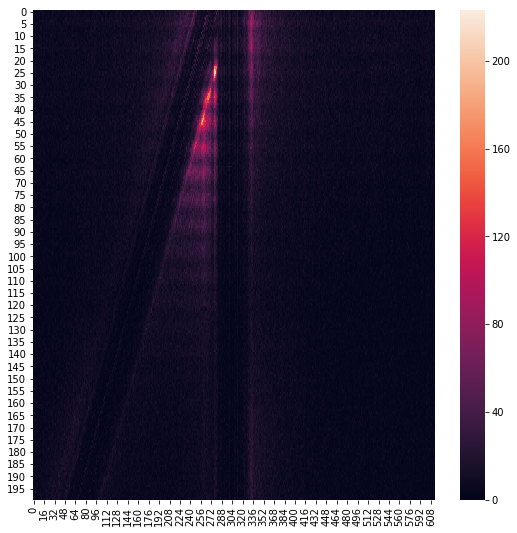

In [13]:
#We have collected our data and stored it by stage, isTrue and cis/trans
#This is what the matric of the true cis sites from "forebrain 0" looks like
plt.figure(figsize=(9,9))
sns.heatmap( data["forebrain_0"][1]["wc"][:200,200:-200]  )

In [14]:
#dump the data in a pickle to use in other notebooks
pickle.dump(data,open("./mm_M6125.pickle","wb"))